In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

def sim_wind(A,CovU,x0,horizon,n_samples):
    #Simula trayectorias de viento
    #A: Matriz de coeficientes de acuerdo a Lutkepohl
    #CovU: Matriz de covarianza ruido U de acuerdo a Lutkhepol
    #x0: puntos de partida a partir del cual se genera el pronostico
    #horizon: horizonte de tiempo hasta el cual se genera el pronostico
    #n_samples: numero de trayectorias a generar
    #x[t] = A_1 x[t-1] + ... + A_p x[t-p] + u[t]
    #A = [A_1,...,A_p]
    #u[t] Normal(0,CovU)
    #x0 = [x[t-1];...;x[t-p]] (; indica abajo, no a la derecha, i.e. formato MATLAB)
    #Formato salida: lista xt[t], donde t corresponde al t-step ahead forecast
    #Cada componente de la lista xt[t] almacena una matriz de dimension (K x n_samples)
    
    #Dimensiones son obtenidas a partir de matrices A, CovU
    Kv = CovU.shape[0] #K (dimension x, i.e. numero centrales)
    pv = int(A.shape[1]/Kv) #p (orden modelo VAR(p))
    
    #Se chequea consistencia con dimensiones x0 (K x p)
    flag_x0 = (x0.shape[0]==(Kv*pv)) and (x0.shape[1]==1)
    if(not(flag_x0)):
        print("ERROR: Las dimensiones de x0 no son consistentes con A,CovU")
        
    #Se chequea horizonte > 0
    if(horizon<1):
        print("ERROR: El horizonte debe ser mayor a 0")
     
    #Simulacion iterativa para todo el horizonte
    xt = np.zeros((Kv,n_samples,horizon))
    x_prev = np.repeat(x0,n_samples,axis=1) #xt de tiempo/iteracion anterior
    #xt_old = []
    for t in range(horizon):
        #generacion ruido aleatorio
        samples = np.random.multivariate_normal(np.zeros(Kv),CovU,size=n_samples)
        
        #modelo VAR(p)
        calc_xt = (A @ x_prev) + np.transpose(samples)
        xt[:,:,t] = calc_xt
        #xt_old.append(calc_xt)
        
        #actualiza x_prev
        x_prev = x_prev[:(Kv*(pv-1)),:]
        x_prev = np.concatenate((calc_xt,x_prev))
        
    return xt
    
def plot_series(xt):
    #Recibe lista xt con pronosticos generados de sim_wind y
    #reordena los datos. Finalmente grafica los resultados.
    
    dim_series = xt.shape[0] #dimension de series de tiempo
    n_samples  = xt.shape[1] #numero de trayectorias generadas
    horizon    = xt.shape[2] #horizonte pronostico
    
    f, axarr = plt.subplots(dim_series,sharex=True)
    for i in range(dim_series):
        for k in range(n_samples):
            axarr[i].plot(xt[i,k,:])
    plt.show()

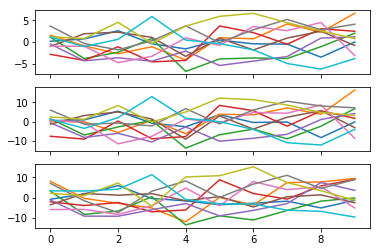

In [2]:
## Wind series simulations

A = np.matrix([[.5,0,0],[.1,.1,.3],[0,.2,.3]]) #[[1,2,3,7,6,1],[2,4,5,6,5,6]]
CovU = np.matrix([[1,2,1],[3,4,1],[1,3,4]])
CovU = CovU @ np.transpose(CovU)
x0 = np.transpose(np.matrix([[0.3,0.4,0.7]])) #0.3,0.4,0.7,0.5,0.7,0.8

horizon = 10
n_samples = 10
time_series = sim_wind(A,CovU,x0,horizon,n_samples)

#Grafica series de tiempos resultantes
plot_series(time_series)

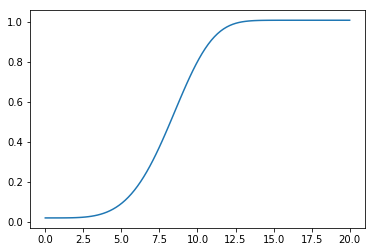

In [3]:
## Wind power curve fitting
def PL5(u,a,b,c,d,g):    
    val = d + (a-d)/((1+(u/c)**b)**g)
    return val

data_csv = pd.read_csv("data_power.csv")
xdata = data_csv['Wind speed (m/s)'].as_matrix()
ydata = data_csv['Power (kW)'].as_matrix()

fit_out = curve_fit(PL5,xdata,ydata,maxfev=10000)

u = np.linspace(0,20,num=100)
a = fit_out[0][0]
b = fit_out[0][1]
c = fit_out[0][2]
d = fit_out[0][3]
g = fit_out[0][4]
plt_out = PL5(u,a,b,c,d,g)

plt.plot(u,plt_out)
plt.show()

cap_wind = 3 #wind plant capacity (eg. 3MW)
def power_curve(u,cap_wind):
    val = PL5(u,a,b,c,d,g)
    val = cap_wind*val
    #wind cut-in and cut-out speed still missing
    return val

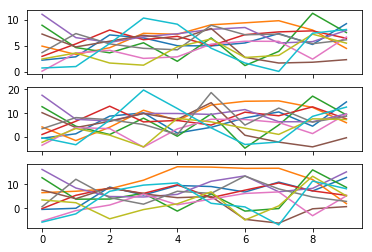

C:\Python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


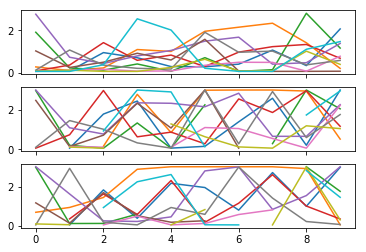

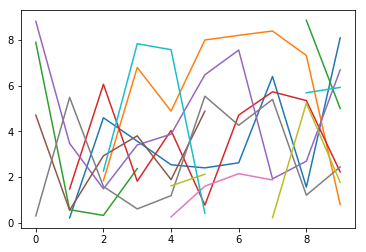

In [5]:
## Apply transformation to simulated wind series: power + sum 

#1) Add ofset to wind_speed
offset_series = time_series + 5
plot_series(offset_series)

#2) Transform to power output
gen_series = power_curve(offset_series)
plot_series(gen_series)

#3) Add for total wind generation
sum_series = np.sum(gen_series,axis=0)
for k in range(sum_series.shape[0]): #shape[0] == n_samples
    plt.plot(sum_series[k,:])
plt.show()